# **Imports**

In [ ]:
from google.colab import drive
# drive.mount('/content/drive') ### I had several timeout errors

drive.mount('/content/drive', timeout_ms=3600000)

Mounted at /content/drive


In [ ]:
!pip install -q pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 12.2 MB/s eta 0:00:00


In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00


In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics --quiet

In [ ]:
import torch
import timm
import pickle

import json
import matplotlib.pyplot as plt

import pandas as pd
import pickle

import os
from os.path import exists, join, basename, splitext
import datetime

import subprocess
import traceback

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split


import torchmetrics
import tqdm


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from typing import Dict, Iterator, List, Union, Optional
import torch.optim as optim

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import pytorch_lightning as pl

import torchvision.models as models

from torchvision.datasets import ImageFolder
from PIL import Image
import os

import wandb

from pytorch_lightning.loggers import WandbLogger

# dataframe & dataset

real images data path

In [ ]:
celeba_path = '/content/drive/MyDrive/Colab Notebooks/Vision/progetto/altri datasetsss/real/CELEBA'

ffhq_path = '/content/drive/MyDrive/Colab Notebooks/Vision/progetto/altri datasetsss/real/FFHQ'

fake images data path

In [ ]:
attgan_path = '/content/drive/MyDrive/Colab Notebooks/Vision/progetto/altri datasetsss/fake/AttGAN (celebA)'
stargan_path = '/content/drive/MyDrive/Colab Notebooks/Vision/progetto/altri datasetsss/fake/STARGAN (celebA)'

stylegan_path = '/content/drive/MyDrive/Colab Notebooks/Vision/progetto/altri datasetsss/fake/STYLEGAN (ffhq)'

## dataframe

ricordati di decommentare e aggiustare le cose

In [ ]:
images_path = []
images_names = []
original_dataset = []
labels = []
def get_name_and_label(path, label, images_path, labels, original_dataset):
  '''
  this function populates 4 lists:
    - images_path : contains the path of each image
    - images_names : contains the name of each image
    - original_dataset : contains the dataset where each image comes from
    - label : 0 if real image, 1 if fake image
  '''
  i = 0

  dataset_name = path.split('/')[-1].split()[0]

  for nome_file in os.listdir(path):
      if int(label) == 1:           ### limit the dataset,
        if i >= 5500:
          break
      else:
        if i >= 12000:
          break

      file_path = os.path.join(path, nome_file)
      name_int = file_path.split('/')
      name = name_int[-1]
      name_2 = name_int[-2]+'_'+name_int[-1]

      # check if the file is an image
      if name.endswith('jpg') or name.endswith('png'):

          images_path.append(file_path)

          images_names.append(name_2)

          original_dataset.append(dataset_name)

          labels.append(label)
      else:
        print(name)

      i+=1

### real images data
get_name_and_label(celeba_path,0,images_path,labels,original_dataset)
get_name_and_label(ffhq_path,0,images_path,labels,original_dataset)

### fake images data
get_name_and_label(attgan_path,1,images_path,labels,original_dataset)
get_name_and_label(stargan_path,1,images_path,labels,original_dataset)
get_name_and_label(stylegan_path,1,images_path,labels,original_dataset)


# pandas dataframe with the elements of the lists images_names, original dataset, images_path and labels
df = pd.DataFrame({'image name': images_names,'original dataset': original_dataset,'file path': images_path, 'label': labels})


df

image name original dataset  \
0               CELEBA_034466.jpg           CELEBA   
1               CELEBA_034892.jpg           CELEBA   
2               CELEBA_034400.jpg           CELEBA   
3               CELEBA_034464.jpg           CELEBA   
4               CELEBA_034716.jpg           CELEBA   
...                           ...              ...   
32495  STYLEGAN (ffhq)_004533.jpg         STYLEGAN   
32496  STYLEGAN (ffhq)_004541.jpg         STYLEGAN   
32497  STYLEGAN (ffhq)_004549.jpg         STYLEGAN   
32498  STYLEGAN (ffhq)_004555.jpg         STYLEGAN   
32499  STYLEGAN (ffhq)_004546.jpg         STYLEGAN   

                                               file path  label  
0      /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
1      /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
2      /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
3      /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
4      /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
...                                                  ...    ...  
32495  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
32496  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
32497  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
32498  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
32499  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  

[32500 rows x 4 columns]

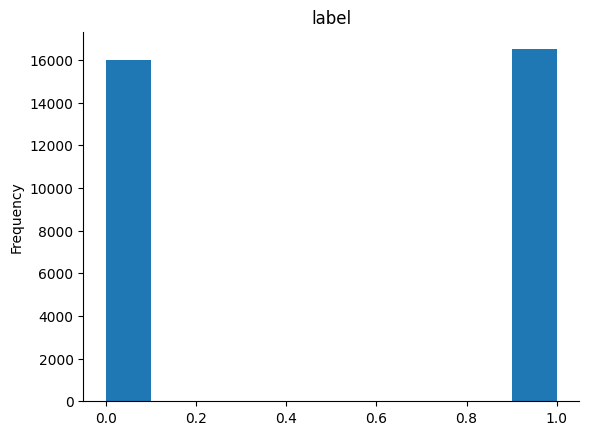

In [ ]:

df['label'].plot(kind='hist',  title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# divide into train, validation and test dataframes
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# check of the number of samples of each dataframe
print("Train:")
print('len: ',len(train_df),'\n',train_df['label'].value_counts())

print("\nValidation:")
print('len: ',len(val_df),'\n',val_df['label'].value_counts())

print("\nTest:")
print('len: ',len(test_df),'\n',test_df['label'].value_counts())

Train:
len:  19500 
 1    9900
0    9600
Name: label, dtype: int64

Validation:
len:  6500 
 1    3300
0    3200
Name: label, dtype: int64

Test:
len:  6500 
 1    3300
0    3200
Name: label, dtype: int64


## Saving & Loading

savings

In [ ]:
## for the train dataframe
train_df_file = open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/train_df.pkl","wb")
pickle.dump(train_df,train_df_file)
train_df_file.close()

## for the validation dataframe
val_df_file = open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/val_df.pkl","wb")
pickle.dump(val_df,val_df_file)
val_df_file.close()

## for the test dataframe
test_df_file = open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/test_df.pkl","wb")
pickle.dump(test_df,test_df_file)
test_df_file.close()

loadings

In [ ]:
## for train
per_train_df=open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/train_df.pkl","rb")
train_df =pickle.load(per_train_df)

## for validation
per_val_df=open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/val_df.pkl","rb")
val_df =pickle.load(per_val_df)

## for test
per_test_df=open("/content/drive/MyDrive/Colab Notebooks/Vision/progetto/test_df.pkl","rb")
test_df =pickle.load(per_test_df)

In [ ]:
print("Train:")
print('len: ',len(train_df),'\n',train_df['label'].value_counts())

print("\nValidation:")
print('len: ',len(val_df),'\n',val_df['label'].value_counts())

print("\nTest:")
print('len: ',len(test_df),'\n',test_df['label'].value_counts())

Train:
len:  19500 
 1    9900
0    9600
Name: label, dtype: int64

Validation:
len:  6500 
 1    3300
0    3200
Name: label, dtype: int64

Test:
len:  6500 
 1    3300
0    3200
Name: label, dtype: int64


## dataset

In [ ]:
class MyDataset(Dataset):
    def __init__(self, df, power=False, both = False):
        '''
        parameters:
          - df: the input dataframe
          - power : (boolean) whether or not to use the image spectrum for classification
          - both : (boolean) whether or not to use both the image spectrum and image tensor

        '''
        self.df = df

        self.both = both

        if self.both == True:
          self.power = True
        else:
          self.power = power


        self.data = []
        for index, row in df.iterrows():
          image_name = row['image name']
          image_path = row['file path']
          original_dataset = row['original dataset']
          label = int(row['label'])

          item = {
              'image_name': image_name,
              'original dataset' : original_dataset,
              'image_path' : image_path,
              'label' : label
          }

          self.data.append(item)




    def get_image_transform(self, img):
        """
        transoforms the image and returns the tensor of it.
        """
        tr = transforms.Compose([

            transforms.Resize((224,224)),
            transforms.ToTensor(),
        ])

        image_transform = tr(img)
        return image_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        '''
          depending on the kind of dataset chosen (with or without power spectrum), this function returns an item of the dataset composed by:
          - input : tensor of the image or the power spectrum tensor (depending on the chosen classification)
          - label : 0 if real image, 1 if fake
          - original dataset: the dataset which the image is part of
          - power_input: the power spectrum tensor (only used if the classification uses both the tensor of the image and power spectrum)
          - real image: the image in PIL format
        '''

        img_path = self.data[idx]['image_path']
        label = int(self.data[idx]['label'])
        image = Image.open(img_path).convert("RGB")
        original_dataset = self.data[idx]['original dataset']


        item = {}
        tr_im = self.get_image_transform(image)

        if self.power == False:


            item = {

                'input': tr_im,
                'label': label,
                'original dataset': original_dataset
            }
        else:   ### gets the tensor of the spectrum (3 channels as the image)
            # from tensor to float
            tr_im_f = tr_im.float()

            # FFT for each channel
            fft_results = [torch.fft.fft2(tr_im_f[channel]) for channel in range(3)]

            # power spectrum for each channel
            power_spectra = [torch.abs(fft_result)**2 for fft_result in fft_results]

            # Tensor of power spectra
            tensor_power_spectra = torch.stack(power_spectra)
            if self.both == True:
              item = {
                  'input' : tr_im,
                  'power input' : tensor_power_spectra,
                  'label' : label,
                  'original dataset': original_dataset
              }

            else:
              item = {
                  'input' : tensor_power_spectra,
                  'label' : label,
                  'real image' : image,
                  'original dataset': original_dataset
              }


        return item

In [ ]:
prova = MyDataset(val_df,True,False)
prova.__len__()

6500

## Display of samples

In [ ]:
prova.__getitem__(3)

{'input': tensor([[[5.5538e+08, 3.0300e+07, 6.3482e+05,  ..., 1.7330e+05,
           6.3482e+05, 3.0300e+07],
          [8.3090e+06, 1.7061e+06, 8.5447e+05,  ..., 3.3212e+05,
           1.2711e+06, 2.3300e+05],
          [7.5588e+06, 1.4395e+05, 3.9568e+05,  ..., 1.9320e+05,
           4.3303e+04, 1.5307e+06],
          ...,
          [6.3612e+05, 6.5030e+05, 1.7472e+05,  ..., 3.9027e+05,
           3.2172e+05, 5.5707e+05],
          [7.5588e+06, 1.5307e+06, 4.3303e+04,  ..., 6.9699e+05,
           3.9568e+05, 1.4395e+05],
          [8.3090e+06, 2.3300e+05, 1.2711e+06,  ..., 8.9666e+05,
           8.5447e+05, 1.7061e+06]],
 
         [[3.8579e+08, 1.9929e+07, 1.5192e+05,  ..., 4.6505e+05,
           1.5192e+05, 1.9929e+07],
          [3.9530e+06, 2.0490e+06, 3.4423e+05,  ..., 1.4395e+05,
           1.4311e+06, 4.5400e+05],
          [4.7695e+06, 1.4252e+05, 5.2610e+05,  ..., 1.3556e+05,
           1.5414e+04, 1.3942e+06],
          ...,
          [4.6094e+05, 6.1304e+05, 1.4031e+05,  .

In [ ]:
  elem =prova.__getitem__(3)

  numpy_array = elem['input'].numpy()

  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)

  plt.figure(figsize=(12, 4))


  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')

  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  plt.title('Original Image')

  # Power Spectrum for the red channel
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))#, cmap='gray')
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum for the green channel
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))#, cmap='gray')
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum for the blue channel
  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))#, cmap='gray')
  plt.title('Log Power Spectrum (Blue)')

  plt.show()


 the label is: 1 , fake image


In [ ]:

  elem =prova.__getitem__(50)

  numpy_array = elem['input'].numpy()

  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)

  plt.figure(figsize=(12, 4))


  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')

  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  plt.title('Original Image')

  # Power Spectrum for the red channel
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))#, cmap='gray')
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum for the green channel
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))#, cmap='gray')
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum for the blue channel
  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))#, cmap='gray')
  plt.title('Log Power Spectrum (Blue)')

  plt.show()


 the label is: 1 , fake image



 the label is: 0 , real image


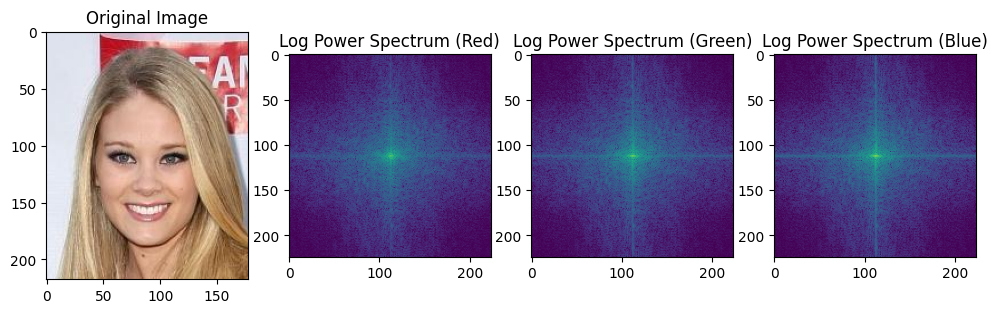

In [ ]:

  elem =prova.__getitem__(23)

  numpy_array = elem['input'].numpy()

  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)

  plt.figure(figsize=(12, 4))


  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')

  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  plt.title('Original Image')

  # Power Spectrum for the red channel
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))#, cmap='gray')
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum for the green channel
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))#, cmap='gray')
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum for the blue channel
  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))#, cmap='gray')
  plt.title('Log Power Spectrum (Blue)')

  plt.show()


 the label is: 0 , real image


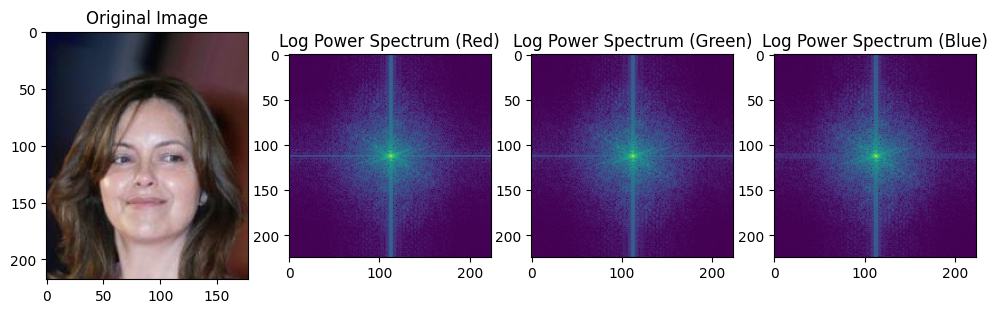

In [ ]:

  elem =prova.__getitem__(18)

  numpy_array = elem['input'].numpy()

  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)

  plt.figure(figsize=(12, 4))


  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')

  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  plt.title('Original Image')

  # Power Spectrum for the red channel
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))#, cmap='gray')
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum for the green channel
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))#, cmap='gray')
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum for the blue channel
  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))#, cmap='gray')
  plt.title('Log Power Spectrum (Blue)')

  plt.show()

# datamodule

In [ ]:
class MyDataModule(pl.LightningDataModule):

    """
        The datamodule class
      The arguments are :

      - batch size: (int) the size of the batch
      - train_df, val_df, test_df: the dataframes
      - use_power: (bool) whether or not to use the power spectrum for classification
      - use_both: (bool) whether or not to use the both the power spectrum and image tensor
    """

    def __init__(
        self,
        batch_size : int,
        train_df,
        val_df,
        test_df,
        use_power = False,
        use_both = False,
        ) -> None:
        super().__init__()

        self.batch_size = batch_size

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.use_power = use_power
        self.use_both = use_both

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit':
            self.train_dataset = MyDataset(self.train_df, self.use_power, self.use_both)
            self.validation_dataset = MyDataset(self.val_df, self.use_power, self.use_both)
        elif stage == 'test':
            self.test_dataset = MyDataset(self.test_df, self.use_power, self.use_both)

    def train_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True, num_workers=2, collate_fn = self.prepare_batch)

    def val_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.validation_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers = 2, collate_fn = self.prepare_batch)

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True, num_workers = 2, collate_fn = self.prepare_batch)

    def prepare_batch(self,batch):
      '''
        My collate_fn used to filter the items of the dataset:
        - input: tensor of the image or the power spectrum (depending on the chosen classification)
        - label: 0 if real, 1 if fake
        - power_input: tensor of the power spectrum (only used if the classification uses both the tensor of the image and power spectrum)
      '''
      prepared_batch = {}
      inputs = [item['input'] for item in batch]
      labels = [item['label'] for item in batch]
      prepared_batch['input'] = torch.stack(inputs)
      prepared_batch['label'] = torch.tensor(labels)

      if self.use_both == True:
        power_inputs = [item['power input'] for item in batch]
        prepared_batch['power input'] = torch.stack(power_inputs)

      return prepared_batch

In [ ]:
prova_dm = MyDataModule(32, train_df, val_df, test_df, False)

# Device

In [ ]:
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Mon Feb 12 18:53:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               8W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# MODELS

In [ ]:

class MyModel(pl.LightningModule):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(4)
        self.pool2 = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(32*13*13, 57)
        self.fc2 = nn.Linear(57, 1)

        self.dropout = nn.Dropout(0.3)    ## other values: 0.5, 0.2, 0.1

        self.accuracy = torchmetrics.Accuracy(task = 'binary')

        self.sigmoid = nn.Sigmoid()


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))

        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))

        x = self.pool2(x)

        x = x.reshape((-1, 32*13*13))

        x = self.dropout(F.relu(self.fc1(x)))

        x = self.fc2(x)

        x = self.sigmoid(x)

        return x

    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)

        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.float().view(-1, 1))

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger = True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):

        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)

        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.float().view(-1, 1))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger = True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger = True)

    def test_step(self, batch, batch_idx):

        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)

        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.view(-1, 1))

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger = True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger = True)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001,) #other lrs: 0.001, 0.01, 0.000001
        return optimizer


In [ ]:

class MyModel_Combined(pl.LightningModule):
    def __init__(self):
        super(MyModel_Combined, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(4)
        self.pool2 = nn.MaxPool2d(4)
        self.fc1 = nn.Linear(32*13*13*2, 57)
        self.fc2 = nn.Linear(57, 1)

        self.dropout = nn.Dropout(0.3)

        self.accuracy = torchmetrics.Accuracy(task = 'binary')

        self.sigmoid = nn.Sigmoid()


    def forward(self, x1, x2):
        # layers for the image tensor
        x1 = F.relu(self.bn1(self.conv1(x1)))
        x1 = self.pool1(x1)
        x1 = F.relu(self.bn2(self.conv2(x1)))
        x1 = self.pool2(x1)
        x1 = x1.reshape((-1, 32*13*13))



        # layers for the image power spectra tensor
        x2 = F.relu(self.bn1(self.conv1(x2)))
        x2 = self.pool1(x2)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x2 = self.pool2(x2)
        x2 = x2.reshape((-1, 32*13*13))

        # Concatenation of the two tensors
        combined = torch.cat([x1, x2], dim=1)

        x = self.dropout(F.relu(self.fc1(combined)))


        x = self.fc2(x)


        x = self.sigmoid(x)

        return x

    def training_step(self, batch, batch_idx):

        inputs = batch['input'].to(device)
        power_inputs = batch['power input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs,power_inputs)

        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.float().view(-1, 1))

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger = True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger = True)
        return loss

    def validation_step(self, batch, batch_idx):

        inputs = batch['input'].to(device)
        power_inputs = batch['power input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs,power_inputs)


        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.float().view(-1, 1))

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger = True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger = True)

    def test_step(self, batch, batch_idx):

        inputs = batch['input'].to(device)
        power_inputs = batch['power input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs,power_inputs)

        loss = F.binary_cross_entropy(outputs, labels.float().view(-1, 1))
        acc = self.accuracy(outputs, labels.view(-1, 1))

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger = True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger = True)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [ ]:
class MyResNet(pl.LightningModule):
    def __init__(self):
        super(MyResNet, self).__init__()
        # resnet
        self.resnet = models.resnet18()

        # modify the last layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)

        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

        self.accuracy = torchmetrics.Accuracy(task = 'binary')

    def forward(self, x):
        x = self.resnet(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x

    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)



        outputs = self(inputs)
        outputs = outputs.squeeze(1)


        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)

        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)
        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [ ]:
class MyAlexNet(pl.LightningModule):


    def __init__(self):
        super(MyAlexNet, self).__init__()
        # alexnet
        self.alexnet = models.alexnet()

        # modify the last layer for binary classification
        num_features = self.alexnet.classifier[-1].in_features
        self.alexnet.classifier[-1] = nn.Linear(num_features, 1)

        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

        self.accuracy = torchmetrics.Accuracy(task = 'binary')

    def forward(self, x):
        x = self.alexnet(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x


    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)



        outputs = self(inputs)
        outputs = outputs.squeeze(1)


        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)

        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)
        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


In [ ]:
class MyXception(pl.LightningModule):


    def __init__(self):
        super(MyXception, self).__init__()
        # xception
        self.xception = timm.create_model('xception')

        # modify the last layer for binary classification
        num_ftrs = self.xception.fc.in_features
        self.xception.fc = nn.Linear(num_ftrs, 1)

        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

        self.accuracy = torchmetrics.Accuracy(task = 'binary')

    def forward(self, x):
        x = self.xception(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x


    def training_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)



        outputs = self(inputs)
        outputs = outputs.squeeze(1)


        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)

        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def test_step(self, batch, batch_idx):
        inputs = batch['input'].to(device)
        labels = batch['label'].to(device)

        outputs = self(inputs)
        outputs = outputs.squeeze(1)
        loss = F.binary_cross_entropy(outputs, labels.float())#.view(-1, 1))
        acc = self.accuracy(outputs, labels)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer


# setup

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# ! wandb login --relogin
# wandb.finish()        ##used when a run is finished

In [ ]:
wandb_logger = WandbLogger(
    project = 'vision_&_perception',
    save_dir = '/content/drive/MyDrive/Colab Notebooks Eren/Vision/progetto',
    log_model = 'all'
)

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_acc',  # the value that will be evaluated to activate the early stopping of the model.
    patience=5,
    verbose=True,
    mode='max',
)

In [ ]:
trainer = pl.Trainer(
    max_epochs=50, #7,10 # maximum number of epochs.
    callbacks=[early_stopping],
    logger = wandb_logger
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


# Fit and Test

## MY MODEL run

### using the images

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = False, use_both=False)


mymodel = MyModel()#MyXception()#MyVGG()#MyResNet()


**Fit**

In [ ]:
trainer.fit(model = mymodel , datamodule= my_dm)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type           | Params
---------------------------------------------
0  | conv1    | Conv2d         | 1.2 K 
1  | conv2    | Conv2d         | 12.8 K
2  | bn1      | BatchNorm2d    | 32    
3  | bn2      | BatchNorm2d    | 64    
4  | pool1    | MaxPool2d      | 0     
5  | pool2    | MaxPool2d      | 0     
6  | fc1      | Linear         | 308 K 
7  | fc2      | Linear         | 58    
8  | dropout  | Dropout        | 0     
9  | accuracy | BinaryAccuracy | 0     
10 | sigmoid  | Sigmoid        | 0     
---------------------------------------------
322 K     Trainable params
0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.933


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.020 >= min_delta = 0.0. New best score: 0.952


Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7d0688caa3b0>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/p

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.006 >= min_delta = 0.0. New best score: 0.966


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.009 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 3 records. Best score: 0.975. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(mymodel, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9725984930992126     │
│         test_loss         │    0.06992819905281067    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.06992819905281067, 'test_acc': 0.9725984930992126}]

In [ ]:
%wandb

in case '%wnadb' does not display the plots

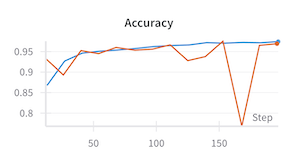

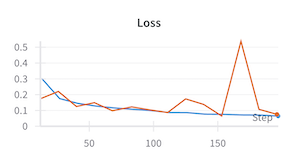

### using the power spectrum

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = True, use_both=False)


mymodel = MyModel()#MyXception()#MyVGG()#MyResNet()


**Fit**

In [ ]:
trainer.fit(model = mymodel , datamodule= my_dm)

wandb: Currently logged in as: cadoli-1837028 (supereeroi). Use `wandb login --relogin` to force relogin
wandb: WARNING Path /content/drive/MyDrive/Colab Notebooks Eren/Vision/progetto/wandb/ wasn't writable, using system temp directory.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type           | Params
---------------------------------------------
0  | conv1    | Conv2d         | 1.2 K 
1  | conv2    | Conv2d         | 12.8 K
2  | bn1      | BatchNorm2d    | 32    
3  | bn2      | BatchNorm2d    | 64    
4  | pool1    | MaxPool2d      | 0     
5  | pool2    | MaxPool2d      | 0     
6  | fc1      | Linear         | 308 K 
7  | fc2      | Linear         | 58    
8  | dropout  | Dropout        | 0     
9  | accuracy | BinaryAccuracy | 0     
10 | sigmoid  | Sigmoid        | 0     
---------------------------------------------
322 K     Trainable params
0         Non-trainable params
322 K     Total params
1.290     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.755


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.106 >= min_delta = 0.0. New best score: 0.861


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.861. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(mymodel, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7730911374092102     │
│         test_loss         │    0.4599035978317261     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.4599035978317261, 'test_acc': 0.7730911374092102}]

In [ ]:
%wandb

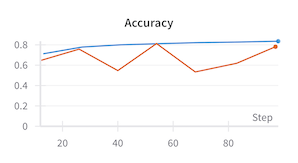

W&B Chart 7_2_2024, 18_50_32.png

## MY MODEL Combined run

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_both=True)


mymodel = MyModel_Combined()#MyXception()#MyVGG()#MyResNet()


**Fit**

In [ ]:
trainer.fit(model = mymodel , datamodule= my_dm)

wandb: Currently logged in as: cadoli-1837028 (supereeroi). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name     | Type           | Params
---------------------------------------------
0  | conv1    | Conv2d         | 1.2 K 
1  | conv2    | Conv2d         | 12.8 K
2  | bn1      | BatchNorm2d    | 32    
3  | bn2      | BatchNorm2d    | 64    
4  | pool1    | MaxPool2d      | 0     
5  | pool2    | MaxPool2d      | 0     
6  | fc1      | Linear         | 616 K 
7  | fc2      | Linear         | 58    
8  | dropout  | Dropout        | 0     
9  | accuracy | BinaryAccuracy | 0     
10 | sigmoid  | Sigmoid        | 0     
---------------------------------------------
630 K     Trainable params
0         Non-trainable params
630 K     Total params
2.523     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.508


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.510


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.063 >= min_delta = 0.0. New best score: 0.573


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.029 >= min_delta = 0.0. New best score: 0.602


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.021 >= min_delta = 0.0. New best score: 0.623


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.623. Signaling Trainer to stop.


In [ ]:
%wandb

In case the command '%wandb' does not work beacuse it requires the login these are the plots


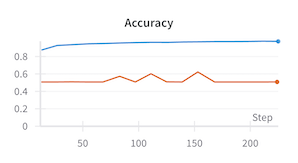



W&B Chart 5_2_2024, 23_09_09.png

**Test**


In [ ]:
trainer.test(mymodel, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5084667205810547     │
│         test_loss         │    0.7758745551109314     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7758745551109314, 'test_acc': 0.5084667205810547}]

con una cnn basilare e immagini semplici ottengo 0.99 di acc in training (sul validation set) e 0.98 su test con una loss di 0.032

## ResNet run

### using the images

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = False, use_both=False)


my_resnet = MyResNet()


**Fit**

In [ ]:
trainer.fit(model = my_resnet , datamodule= my_dm)

wandb: Currently logged in as: riccardo-cadoli3. Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params
--------------------------------------------
0 | resnet   | ResNet         | 11.2 M
1 | dropout  | Dropout        | 0     
2 | sigmoid  | Sigmoid        | 0     
3 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.973


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.975


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.992


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.997


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.997. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(my_resnet, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9948979616165161     │
│         test_loss         │   0.016458040103316307    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.016458040103316307, 'test_acc': 0.9948979616165161}]

In [ ]:
%wandb

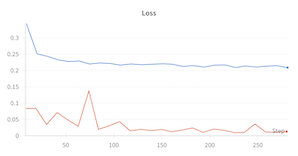


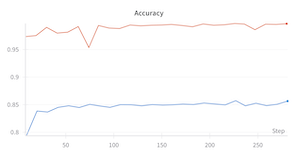

### using the power spectrum

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = True, use_both=False)


my_resnet = MyResNet()


**Fit**

In [ ]:
trainer.fit(model = my_resnet , datamodule= my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params
--------------------------------------------
0 | resnet   | ResNet         | 11.2 M
1 | dropout  | Dropout        | 0     
2 | sigmoid  | Sigmoid        | 0     
3 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.708    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.508


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.339 >= min_delta = 0.0. New best score: 0.847


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.847. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(my_resnet, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8497023582458496     │
│         test_loss         │    0.3225356638431549     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3225356638431549, 'test_acc': 0.8497023582458496}]

In [ ]:
%wandb

resnet power losss.png


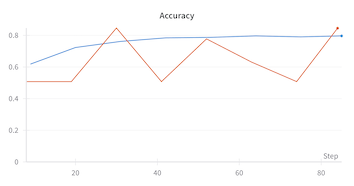

## Xception run

### using the images

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = False, use_both=False)


my_xce = MyXception()


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


**Fit**

In [ ]:
trainer.fit(model = my_xce , datamodule= my_dm)

wandb: Currently logged in as: cadoli-1837028 (supereeroi). Use `wandb login --relogin` to force relogin
wandb: WARNING Path /content/drive/MyDrive/Colab Notebooks Eren/Vision/progetto/wandb/ wasn't writable, using system temp directory.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params
--------------------------------------------
0 | xception | Xception       | 20.8 M
1 | dropout  | Dropout        | 0     
2 | sigmoid  | Sigmoid        | 0     
3 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
20.8 M    Trainable params
0         Non-trainable params
20.8 M    Total params
83.236    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.970


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.986


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.003 >= min_delta = 0.0. New best score: 0.989


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.990


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.991


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.000 >= min_delta = 0.0. New best score: 0.991


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.994


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.002 >= min_delta = 0.0. New best score: 0.996


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.996. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(my_xce, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9908588528633118     │
│         test_loss         │   0.026208415627479553    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.026208415627479553, 'test_acc': 0.9908588528633118}]

In [ ]:
%wandb

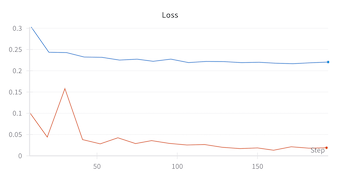

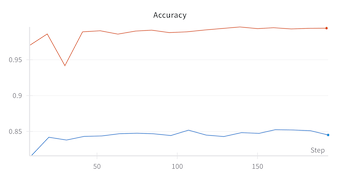

### using the power spectrum

In [ ]:
my_dm= MyDataModule(32, train_df, val_df, test_df, use_power = True, use_both=False)


my_xce = MyXception()


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


**Fit**

In [ ]:
trainer.fit(model = my_xce , datamodule= my_dm)

wandb: Currently logged in as: cadoli-1837028 (supereeroi). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type           | Params
--------------------------------------------
0 | xception | Xception       | 20.8 M
1 | dropout  | Dropout        | 0     
2 | sigmoid  | Sigmoid        | 0     
3 | accuracy | BinaryAccuracy | 0     
--------------------------------------------
20.8 M    Trainable params
0         Non-trainable params
20.8 M    Total params
83.236    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved. New best score: 0.508


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.091 >= min_delta = 0.0. New best score: 0.599


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_acc improved by 0.053 >= min_delta = 0.0. New best score: 0.652


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_acc did not improve in the last 5 records. Best score: 0.652. Signaling Trainer to stop.


**Test**


In [ ]:
trainer.test(my_xce, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5076530575752258     │
│         test_loss         │     5.236474514007568     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.236474514007568, 'test_acc': 0.5076530575752258}]

In [ ]:
%wandb

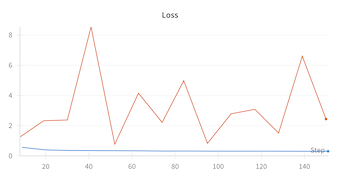


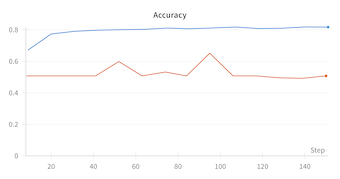

# Generalization

In [ ]:

images_path = []
images_names = []
original_dataset = []
labels = []

def get_images_from_nested_folders(root_path, images_path, labels, original_dataset, label_map):
  ''' it is the same function used for the train, validation and test dataframes,
  the difference is that this time the images are stored in sub-folders divided in categories.
  For example: image 'x' is 0_real/television

  '''

    for dirpath, dirnames, filenames in os.walk(root_path):
        # Filtra solo i file che terminano con .jpg o .png
        image_files = [f for f in filenames if f.endswith(('jpg', 'png'))]

        # Se ci sono immagini nella cartella corrente
        if image_files:
            dataset_name = dirpath.split('/')[-1]
            label = label_map.get(dataset_name, 'default_label')

            for nome_file in image_files:
                file_path = os.path.join(dirpath, nome_file)
                name_int = file_path.split('/')
                name = name_int[-1]
                name_2 = name_int[-2] + '_' + name_int[-1]

                images_path.append(file_path)
                images_names.append(name_2)
                original_dataset.append(dataset_name)
                labels.append(label)

# map of labels
label_map = {
    '0_real': 0,
    '1_fake': 1,
}

###paths
root1 = "/content/drive/MyDrive/Colab Notebooks/Vision/progetto/img_data/test"

root2 = "/content/drive/MyDrive/Colab Notebooks/Vision/progetto/img_data/val"


get_images_from_nested_folders(root1, images_path, labels, original_dataset, label_map)

get_images_from_nested_folders(root2, images_path, labels, original_dataset, label_map)

###dataframe

gen_df = pd.DataFrame({'image name': images_names,'original dataset': original_dataset,'file path': images_path, 'label': labels})

gen_df = gen_df.sample(frac=1, random_state=42).reset_index(drop=True)

gen_df

image name original dataset  \
0     0_real_03061.png           0_real   
1     1_fake_03508.png           1_fake   
2     1_fake_04993.png           1_fake   
3     0_real_02250.png           0_real   
4     0_real_04944.png           0_real   
...                ...              ...   
2395  0_real_03092.png           0_real   
2396  0_real_00226.png           0_real   
2397  1_fake_00737.png           1_fake   
2398  1_fake_04604.png           1_fake   
2399  1_fake_00737.png           1_fake   

                                              file path  label  
0     /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
1     /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
2     /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
3     /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
4     /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
...                                                 ...    ...  
2395  /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
2396  /content/drive/MyDrive/Colab Notebooks/Vision/...      0  
2397  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
2398  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  
2399  /content/drive/MyDrive/Colab Notebooks/Vision/...      1  

[2400 rows x 4 columns]

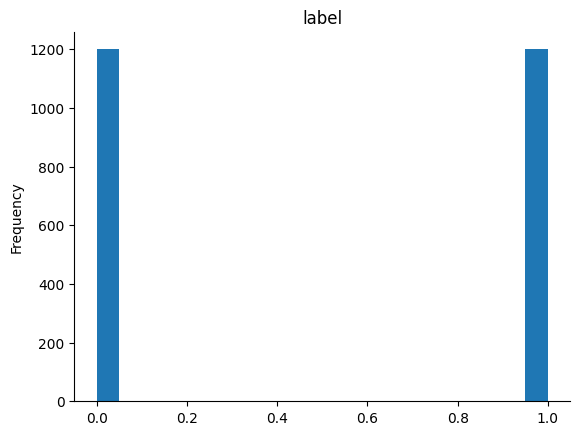

In [ ]:
from matplotlib import pyplot as plt
gen_df['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
gen_dataset = MyDataset(gen_df,True,False)
gen_dataset.__len__()

2400

## Display of samples

In [ ]:
gen_dataset.__getitem__(1)

{'input': tensor([[[1.5411e+09, 3.8625e+06, 1.1744e+06,  ..., 2.9875e+06,
           1.1744e+06, 3.8625e+06],
          [5.2164e+06, 1.8833e+06, 1.1776e+06,  ..., 1.1749e+06,
           5.2110e+04, 3.3264e+06],
          [2.5714e+05, 1.4048e+06, 1.8912e+05,  ..., 3.2791e+05,
           1.3254e+06, 1.9946e+06],
          ...,
          [1.0906e+06, 4.3206e+05, 2.2422e+06,  ..., 3.3707e+05,
           3.3749e+05, 1.0948e+06],
          [2.5714e+05, 1.9946e+06, 1.3254e+06,  ..., 2.1947e+06,
           1.8912e+05, 1.4048e+06],
          [5.2164e+06, 3.3264e+06, 5.2110e+04,  ..., 1.0622e+05,
           1.1776e+06, 1.8833e+06]],
 
         [[1.5380e+09, 3.8065e+06, 1.1444e+06,  ..., 2.8511e+06,
           1.1444e+06, 3.8065e+06],
          [5.3709e+06, 1.9097e+06, 1.1608e+06,  ..., 1.1865e+06,
           7.9816e+04, 3.3104e+06],
          [2.7645e+05, 1.4021e+06, 2.2988e+05,  ..., 3.6854e+05,
           1.3877e+06, 2.0434e+06],
          ...,
          [1.0637e+06, 3.9658e+05, 2.1494e+06,  .


 the label is: 1 , fake image


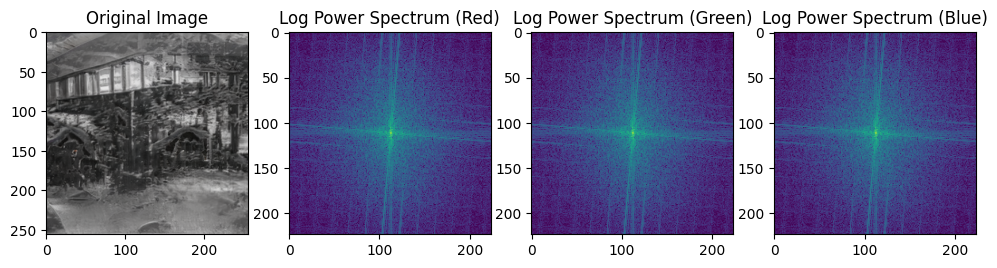

In [ ]:

  elem =gen_dataset.__getitem__(2)





  numpy_array = elem['input'].numpy()


  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)
  # Visualizza l'immagine originale e i Power Spectrum per ogni canale
  plt.figure(figsize=(12, 4))

  #
  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')
  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  # plt.axis('off') # Nascondi gli assi
  plt.title('Original Image')

  # Power Spectrum per il canale Rosso
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))#, cmap='gray')
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum per il canale Verde
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))#, cmap='gray')
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum per il canale Blu
  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))#, cmap='gray')
  plt.title('Log Power Spectrum (Blue)')

  plt.show()




 the label is: 0 , real image


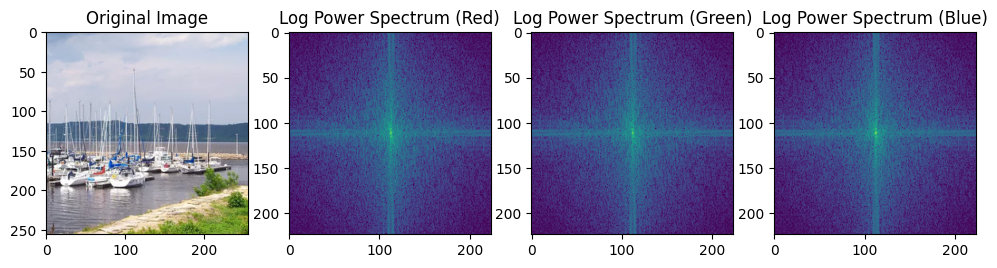

In [ ]:
  elem =gen_dataset.__getitem__(8)





  numpy_array = elem['input'].numpy()


  power_spectra = []
  for p in elem['input']:
    n = p.numpy()
    power_spectra.append(n)
  plt.figure(figsize=(12, 4))

  #
  if elem['label'] == 0:
    print('\n the label is:',elem['label'],', real image')
  else:
    print('\n the label is:',elem['label'],', fake image')
  ## Original image
  plt.subplot(1, 4, 1)
  plt.imshow(elem['real image'])
  plt.title('Original Image')

  # Power Spectrum for Red channel
  plt.subplot(1, 4, 2)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[0])))
  plt.title('Log Power Spectrum (Red)')

  # Power Spectrum for green channel
  plt.subplot(1, 4, 3)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[1])))
  plt.title('Log Power Spectrum (Green)')

  # Power Spectrum on blue channel

  plt.subplot(1, 4, 4)
  plt.imshow(np.log(1 + np.fft.fftshift(power_spectra[2])))
  plt.title('Log Power Spectrum (Blue)')

  plt.show()

## Testing

In [ ]:
def prepare_batch(batch):
      prepared_batch = {}
      inputs = [item['input'] for item in batch]
      labels = [item['label'] for item in batch]
      prepared_batch['input'] = torch.stack(inputs)
      prepared_batch['label'] = torch.tensor(labels)


      return prepared_batch

In [ ]:
new_test_dataloader = DataLoader(gen_dataset, batch_size=32, shuffle=False)

In [ ]:
trainer.test(mymodel, my_dm)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.509353756904602     │
│         test_loss         │     5.217265605926514     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.217265605926514, 'test_acc': 0.509353756904602}]